<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/examples/1D/Multispecies-SOD/1D_SOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [ ]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/JA4S/JANC.git
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/1D/Multispecies-SOD/He-N2.yaml
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/1D/Multispecies-SOD/exact.mat

In [ ]:
from janc_v2.model import thermo_model
from janc_v2.preprocess import nondim
from janc_v2.simulation import set_simulator
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Example : 1D Multispecies-SOD

# Set grid, thermodynamics, reaction, and flux solver

In [ ]:
#grid config
Lx = 10.0
nx = 200
dx = Lx/nx
grid_config = {'dx':dx}

#nondim_config
nondim_config = {'P0':1e5,'T0':1.0,'R0':1.0,'x0':1.0}
nondim.set_nondim(nondim_config)
#thermo_config
thermo_config = {'thermo_model':'nasa7',
          'mechanism_directory':'He-N2.yaml'}
thermo_model.set_thermo(thermo_config,nondim_config,dim='1D')
#reaction_config
#there is no reaction activated in this case
reaction_config = {'is_detailed_chemistry':False
           }
#flux_config
flux_config = {'solver_type':'godunov',
        'interface_reconstruction':'MUSCL',
        'riemann_solver':'HLLC',
        'viscosity':'off'
        }

# Set boundary conditions

In [ ]:
boundary_config = {'left_boundary':'zero_gradient',
          'right_boundary':'zero_gradient'}

# Initializations

In [ ]:
time_control = {'temporal_evolution_scheme':'RK2',
         'CFL':0.20,
         't_end':2.0}
simulation_config = {'dimension':'1D',
            'grid_config':grid_config,
            'thermo_config':thermo_config,
            'reaction_config':reaction_config,
            'flux_config':flux_config,
            'boundary_config':boundary_config,
            'time_config':time_control}
Simulator = set_simulator.Simulator(simulation_config)

In [ ]:
def initial_conditions(UL,UR):
    rhoL, rhouL, pL, YL = UL
    rhoR, rhouR, pR, YR = UR

    rho_init = jnp.full((1,nx),rhoL)
    rho_init = rho_init.at[:,round(nx/2):].set(rhoR)
    rhou_init = jnp.zeros((1,nx))
    P_init = jnp.full((1,nx),pL)
    P_init = P_init.at[:,round(nx/2):].set(pR)
    Y_init = jnp.full((1,nx),YL)
    Y_init = Y_init.at[:,round(nx/2):].set(YR)
    R_init = thermo_model.get_R(Y_init)
    T_init = P_init/(rho_init*R_init)
    _,gamma_init,h_init,_,_ = thermo_model.get_thermo(T_init,Y_init)
    E_init = rho_init*h_init - P_init

    U_init = jnp.concatenate([rho_init,rhou_init,E_init,rho_init*Y_init],axis=0)
    aux_init = jnp.concatenate([gamma_init,T_init],axis=0)
    return U_init,aux_init

UL = (1.0,0.0,1.0,0.0)
UR = (0.125,0.0,0.1,1.0)
U, aux = initial_conditions(UL,UR)

# Main loop of time advance

In [ ]:
U_final, aux_final, t_final = Simulator.run(U,aux)

Simulation: 100%|██████████| 2.0/2.0 [00:05<00:00]


# Postprocess

In [ ]:
#t = 2.0 (t_end)
time, state_dict = Simulator.saver.load('save_step1')#save_step0 always stores initial conditions
rho = state_dict['density']
p = state_dict['pressure']

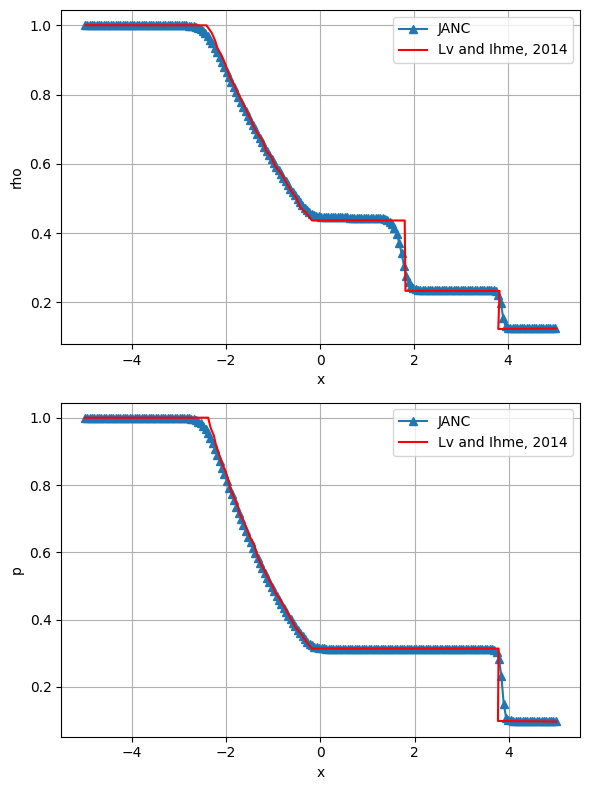

In [ ]:
exact_data = sio.loadmat('exact.mat')
p_exact = exact_data['p_exact']
rho_exact = exact_data['rho_exact']
x = np.linspace(-5,5,nx)

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(x, rho, '-^', label='JANC')
plt.plot(rho_exact[:,0], rho_exact[:,1], '-r', label='Lv and Ihme, 2014')
plt.xlabel('x')
plt.ylabel('rho')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(x, p, '-^', label='JANC')
plt.plot(p_exact[:,0], p_exact[:,1], '-r', label='Lv and Ihme, 2014')
plt.xlabel('x')
plt.ylabel('p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

